In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('Housing.csv')


In [19]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train['bed_to_bath'] = X_train['bedrooms'] / (X_train['bathrooms'] + 1)  # se suma 1 para evitar división por cero
X_test['bed_to_bath'] = X_test['bedrooms'] / (X_test['bathrooms'] + 1)

X_train['rooms'] = X_train['bedrooms'] + X_train['bathrooms']
X_test['rooms'] = X_test['bedrooms'] + X_test['bathrooms']

X_train['area_per_room'] = X_train['area'] / (X_train['rooms'] + 1)
X_test['area_per_room'] = X_test['area'] / (X_test['rooms'] + 1)

X_train['area_per_story'] = X_train['area'] / (X_train['stories'] + 1)
X_test['area_per_story'] = X_test['area'] / (X_test['stories'] + 1)

X_train['parking_per_story'] = X_train['parking'] / (X_train['stories'] + 1)
X_test['parking_per_story'] = X_test['parking'] / (X_test['stories'] + 1)



In [20]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

# Transformación logarítmica personalizada
def log_transform(x):
    return np.log(x + 1)

# Columnas según tipo
# Actualizar la lista de variables numéricas
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 
                    'bed_to_bath', 'rooms', 'area_per_room', 'area_per_story', 'parking_per_story']

categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
ordinal_features = ['furnishingstatus']

# Categorías ordinales
ordinal_categories = [['unfurnished', 'semi-furnished', 'furnished']]

# Pipeline numérico: imputación + transformación logarítmica + escalado robusto
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(log_transform)),
    ('scaler', RobustScaler())
])

# Pipeline categórico: imputación + One-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Pipeline ordinal: imputación + Ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(
        categories=ordinal_categories,
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

# Combinar pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Normalización variable objetivo
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"Forma de X_train_processed: {X_train_processed.shape}")


Forma de X_train_processed: (436, 17)


In [21]:
import tensorflow as tf

num_features = X_train_processed.shape[1]

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_model()
model.summary()


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_processed, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9473 - mae: 0.7965 - val_loss: 0.8734 - val_mae: 0.7659
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9154 - mae: 0.7583 - val_loss: 0.8408 - val_mae: 0.7473
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8481 - mae: 0.7134 - val_loss: 0.8115 - val_mae: 0.7301
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7220 - mae: 0.6388 - val_loss: 0.7860 - val_mae: 0.7141
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9631 - mae: 0.7625 - val_loss: 0.7611 - val_mae: 0.6981
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7616 - mae: 0.6910 - val_loss: 0.7375 - val_mae: 0.6834
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6532 - mae: 0.6325 - val_loss: 0.7158 - val_mae: 0.6693
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7418 - mae: 0.6501 - val_loss: 0.6933 - val_mae: 0.6574
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.63

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Resultados en Test:
MSE: 1947434745856.00
RMSE: 1395505.19
RMSE (%): 27.87%
MAE: 1018062.38
R²: 0.61


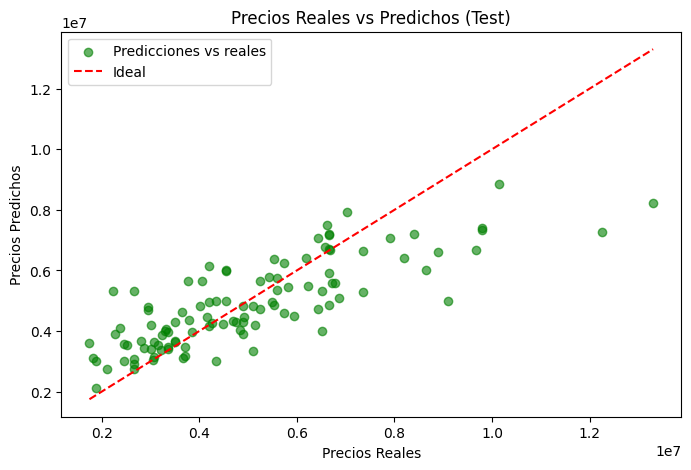

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Predicción
y_pred_scaled = model.predict(X_test_processed)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_test.values.reshape(-1, 1)

# Métricas
mse_test = mean_squared_error(y_true, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_true, y_pred)
r2_test = r2_score(y_true, y_pred)
rmse_percent = (rmse_test / np.mean(y_true)) * 100

print("Resultados en Test:")
print(f"MSE: {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"RMSE (%): {rmse_percent:.2f}%")
print(f"MAE: {mae_test:.2f}")
print(f"R²: {r2_test:.2f}")

# Gráfico visual
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.6, color='green', label='Predicciones vs reales')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')
plt.xlabel('Precios Reales')
plt.ylabel('Precios Predichos')
plt.title('Precios Reales vs Predichos (Test)')
plt.legend()
plt.show()
